# Quick Analysis of Heat Pump Data from Germany

Some time back I came across the article [Dataset on electrical single-family house and heat pump load profiles in Germany](https://www.nature.com/articles/s41597-022-01156-1) published in *Nature: Scientific Data*, in which the authors made available the following electric power data (referred to as *WPuQ* in the article) of heat pumps from 18 different households in Germany and the weather data:

* Electrical power data for heat pumps at 60-minutes, 15-minutes, 1-minute, and 1-second intervals for 2018, 2019 and 2020 for x different households in Germany. 
* The weather data at corresponding intervals.

From the paper:

> *Here, we present a dataset, covering measurements, which were carried out within the framework of the research project Wind-Solar-Heat Pump District (WPuQ) from 2018 to 2020 in 38 single-family households in a district in Lower-Saxony, Germany. We provide measurements of the electrical household load for three phases of voltage, current, active, apparent and reactive power in a 10-second resolution. Additionally, separate measurements of electrical loads of the heat pumps installed in each building and of the electrical substation with the aggregated load of 68 households in total are available.*

and:

> *The measurements are part of the WPuQ project and take place in an enclosed district near
Hamelin in Lower Saxony, Germany. The district consists of 68 single-family houses built in the late 90 s and early
2000s and all houses comply with the low-energy standard with a specific heat demand of about 45–50 kWh/
(m 2 a) 11 . All buildings are equipped with water-water-heat pumps connected to a cold local heating network and
solar thermal systems for domestic hot water (DHW) [...].*

The data in the above article is given in `hdf5` format, which is perhaps not such a typical format. For some time I've been wanting to have a closer look at the data to see if any insights can be obtained. As a start, I will in this article go through the data extraction process and present a few initial analyses.

Let us begin with downloading the data. The data in the above article is hosted at https://zenodo.org/records/5642902 and is spread across several downloadable `hdf5` files. It is about 37 GB in total, so be careful what you download! For purposes of this post I will download the following files 

* `2018_data_60min.hdf5`
* `2018_weather.hdf5`
* `2019_data_60min.hdf5`
* `2019_weather.hdf5`. 

These are more than 200 MB in size and contain data at 60-minutes intervals for 2018 and 2019.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py

## Reading the data

For reading hdf5 files the `h5py` package is needed. This can be easily installed with `pip`:

`pip install h5py`

After you have installed it you can read the data as shown below, where I read in the weather data:

In [2]:
filename = "/home/kbhaskar/Github_Repos/DataScience/DataVisualization/2018_weather.hdf5"
f = h5py.File(filename, 'r')

`hdf5` files save data in a directory-like structure. The "directories" at each level can be seen with the `keys()` method. At the initial level the "directories"  are given by:

In [3]:
print(list(f.keys()))

['WEATHER_SERVICE']


There is only one directory at this level, namely `WEATHER_SERVICE`. Let's check the directories at the next level: 

In [4]:
print(list(f["WEATHER_SERVICE"].keys()))

['IN']


Here again there is only one directory, namely `in`. Continuing again:

In [5]:
print(list(f["WEATHER_SERVICE"]["IN"].keys()))

['WEATHER_APPARENT_TEMPERATURE_TOTAL', 'WEATHER_ATMOSPHERIC_PRESSURE_TOTAL', 'WEATHER_PRECIPITATION_RATE_TOTAL', 'WEATHER_PROBABILITY_OF_PRECIPITATION_TOTAL', 'WEATHER_RELATIVE_HUMIDITY_TOTAL', 'WEATHER_SOLAR_IRRADIANCE_GLOBAL', 'WEATHER_TEMPERATURE_TOTAL', 'WEATHER_WIND_DIRECTION_TOTAL', 'WEATHER_WIND_GUST_SPEED_TOTAL', 'WEATHER_WIND_SPEED_TOTAL']


So this is where the weather data is available, which includes various variables such as pressure, temperature, humidity, etc. For purposes of this article we are interested in the outside temperature which is given by `WEATHER_TEMPERATURE_TOTAL`. Again using the `keys()` method, we can see that there is only one directory at this level, called `table`:

In [6]:
print(list(f["WEATHER_SERVICE"]["IN"]["WEATHER_TEMPERATURE_TOTAL"].keys()))

['table']


There are no more directories at this level, as can be checked again with `keys()`: using it again will throw up an attribute error. So this is the level where the data is saved. This can be read as a numpy array as follows by adding `[()]` at the end. The `[()]` converts the `hdf5` object into a numpy array:

In [7]:
f["WEATHER_SERVICE"]["IN"]["WEATHER_TEMPERATURE_TOTAL"]["table"][()]

array([(1514764800000000000, 9.80000019),
       (1514768400000000000, 9.80000019),
       (1514772000000000000, 9.19999981), ...,
       (1546296600000000000, 8.39999962),
       (1546296900000000000, 8.39999962),
       (1546297200000000000, 8.39999962)],
      dtype=[('index', '<i8'), ('TEMPERATURE:TOTAL', '<f8')])

The first column named `index` consists of UNIX time stamps in nanoseconds. The second column named `TEMPERATURE:TOTAL` consists of the temperature. We will now do the following steps:

* convert the above array into a pandas dataframe.
* introduce a new column `datetime` in the above dataframe which converts the `index` column from UNIX timestamps into a pandas DateTime series.
* rename the column `TEMPERATURE:TOTAL` as `TM`.

In [8]:
# convert to pandas dataframe:
df = pd.DataFrame(f["WEATHER_SERVICE"]["IN"]["WEATHER_TEMPERATURE_TOTAL"]["table"][()])
# introduce column datumzeit:
df["datumzeit"] = pd.to_datetime(df["index"], unit="ns")
# rename the columns TEMPERATURE:TOTAL as TM
df = df.rename(columns={"TEMPERATURE:TOTAL":"TM"})
df

,index,TM,datumzeit
0,1514764800000000000,9.8,2018-01-01 00:00:00
1,1514768400000000000,9.8,2018-01-01 01:00:00
2,1514772000000000000,9.2,2018-01-01 02:00:00
3,1514775600000000000,8.4,2018-01-01 03:00:00
4,1514779200000000000,8.5,2018-01-01 04:00:00
...,...,...,...
49074,1546296000000000000,8.5,2018-12-31 22:40:00
49075,1546296300000000000,8.4,2018-12-31 22:45:00
49076,1546296600000000000,8.4,2018-12-31 22:50:00
49077,1546296900000000000,8.4,2018-12-31 22:55:00


See that the column for temperature after converting the array to a dataframe is `TEMPERATURE:TOTAL`, whereas the key name  was `WEATHER_TEMPERATURE_TOTAL`. Similarly, the key names and column names of the other weather  variables are different. For example, the key name `WEATHER_ATMOSPHERIC_PRESSURE_TOTAL` corresponds to a column name `ATMOSPHERIC_PRESSURE:TOTAL`, as can be seen:

In [9]:
f["WEATHER_SERVICE"]["IN"]["WEATHER_ATMOSPHERIC_PRESSURE_TOTAL"]["table"][()]

array([(1514764800000000000,  998.70001221),
       (1514768400000000000,  998.79998779),
       (1514772000000000000,  998.90002441), ...,
       (1546296600000000000, 1030.09997559),
       (1546296900000000000, 1030.09997559),
       (1546297200000000000, 1030.09997559)],
      dtype=[('index', '<i8'), ('ATMOSPHERIC_PRESSURE:TOTAL', '<f8')])

We can use the information of the key names and the corresponding names to create a function to extract the weather variable of our choice. Before doing so, note that certain timestamps are repeated in the weather data, as we can see below with the `value_counts()` method:

In [10]:
pd.DataFrame(f["WEATHER_SERVICE"]["IN"]["WEATHER_ATMOSPHERIC_PRESSURE_TOTAL"]["table"][()])["index"].value_counts()

1525125600000000000    2
1541026800000000000    2
1525989600000000000    2
1515625200000000000    2
1517439600000000000    2
                      ..
1536415500000000000    1
1536415800000000000    1
1536416100000000000    1
1536416400000000000    1
1546297200000000000    1
Name: index, Length: 48988, dtype: int64

The repetitions can be removed using the `drop_duplicates()` method of pandas in the function. In addition, we define the following variables which will be useful in the function:

In [11]:
key_names = ['WEATHER_APPARENT_TEMPERATURE_TOTAL', 
             'WEATHER_ATMOSPHERIC_PRESSURE_TOTAL', 
             'WEATHER_PRECIPITATION_RATE_TOTAL', 
             'WEATHER_PROBABILITY_OF_PRECIPITATION_TOTAL', 
             'WEATHER_RELATIVE_HUMIDITY_TOTAL', 
             'WEATHER_SOLAR_IRRADIANCE_GLOBAL', 
             'WEATHER_TEMPERATURE_TOTAL', 
             'WEATHER_WIND_DIRECTION_TOTAL', 
             'WEATHER_WIND_GUST_SPEED_TOTAL', 
             'WEATHER_WIND_SPEED_TOTAL']

names_dict = {"APPARENT_TEMPERATURE:TOTAL" : "TM_APPARENT",
              "ATMOSPHERIC_PRESSURE:TOTAL" : "ATM_PRESSURE",
              "PRECIPITATION_RATE:TOTAL"   : "PREC_RATE",
              "PROBABILITY_OF_PRECIPITATION:TOTAL": "PREC_PROB",
              "RELATIVE_HUMIDITY:TOTAL"    : "REL_HUM",
              "SOLAR_IRRADIANCE:GLOBAL"    : "SOL_IRR",
              "TEMPERATURE:TOTAL"          : "TM",
              "WIND_DIRECTION:TOTAL"       : "WIND_DIR",
              "WIND_GUST_SPEED:TOTAL"      : "WIND_GUST_SPEED",
              "WIND_SPEED:TOTAL"           : "WIND_SPEED"}

key_names_dict = {'WEATHER_APPARENT_TEMPERATURE_TOTAL' : "TM_APPARENT",
             'WEATHER_ATMOSPHERIC_PRESSURE_TOTAL'      : "ATM_PRESSURE",
             'WEATHER_PRECIPITATION_RATE_TOTAL'        : "PREC_RATE",
             'WEATHER_PROBABILITY_OF_PRECIPITATION_TOTAL': "PREC_PROB",
             'WEATHER_RELATIVE_HUMIDITY_TOTAL'         : "REL_HUM",
             'WEATHER_SOLAR_IRRADIANCE_GLOBAL'         : "SOL_IRR",
             'WEATHER_TEMPERATURE_TOTAL'               : "TM",
             'WEATHER_WIND_DIRECTION_TOTAL'            : "WIND_DIR",
             'WEATHER_WIND_GUST_SPEED_TOTAL'           : "WIND_GUST_SPEED",
             'WEATHER_WIND_SPEED_TOTAL'                : "WIND_SPEED"}

And finally here is the function for extracting the any weather variable.

In [12]:
def get_weather(year=2018, var="WEATHER_TEMPERATURE_TOTAL"):
    """returns weather data
    :param var: a string
    :return: pandas dataframe of the weather
    :rtype: pandas dataframe
    """
    filename = "./{}_weather.hdf5".format(year)
    f = h5py.File(filename, 'r')
    dfweather =  pd.DataFrame(f["WEATHER_SERVICE"]["IN"][var]["table"][()])
    dfweather["datumzeit"] = pd.to_datetime(dfweather["index"], unit="ns")
    dfweather = dfweather.rename(columns=names_dict)
    dfweather = dfweather.drop_duplicates(subset="datumzeit")
    return dfweather

As a start, let us extract the temperature and the solar radiation with help of the above function and plot the data.

In [13]:
# extract the temperature data
df_weather_TM_2018 = get_weather(year= 2018, var="WEATHER_TEMPERATURE_TOTAL")
df_weather_TM_2018

,index,TM,datumzeit
0,1514764800000000000,9.8,2018-01-01 00:00:00
1,1514768400000000000,9.8,2018-01-01 01:00:00
2,1514772000000000000,9.2,2018-01-01 02:00:00
3,1514775600000000000,8.4,2018-01-01 03:00:00
4,1514779200000000000,8.5,2018-01-01 04:00:00
...,...,...,...
49074,1546296000000000000,8.5,2018-12-31 22:40:00
49075,1546296300000000000,8.4,2018-12-31 22:45:00
49076,1546296600000000000,8.4,2018-12-31 22:50:00
49077,1546296900000000000,8.4,2018-12-31 22:55:00


In [14]:
# extract the solar radiation data
df_weather_IRR_2018 = get_weather(2018, "WEATHER_SOLAR_IRRADIANCE_GLOBAL")
df_weather_IRR_2018

,index,SOL_IRR,datumzeit
0,1514764800000000000,0.0,2018-01-01 00:00:00
1,1514768400000000000,0.0,2018-01-01 01:00:00
2,1514772000000000000,0.0,2018-01-01 02:00:00
3,1514775600000000000,0.0,2018-01-01 03:00:00
4,1514779200000000000,0.0,2018-01-01 04:00:00
...,...,...,...
48922,1546296000000000000,0.0,2018-12-31 22:40:00
48923,1546296300000000000,0.0,2018-12-31 22:45:00
48924,1546296600000000000,0.0,2018-12-31 22:50:00
48925,1546296900000000000,0.0,2018-12-31 22:55:00


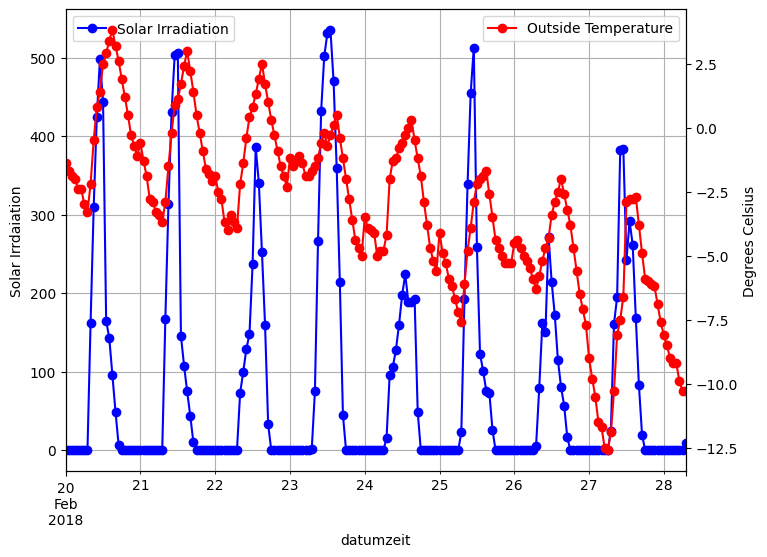

In [15]:
# plot a subset of the data
fig,ax=plt.subplots(figsize=(8,6))
axtwin = ax.twinx()
df_weather_IRR_2018.iloc[1200:1400].plot(x="datumzeit", y="SOL_IRR", ax=ax, marker="o", color="blue")
df_weather_TM_2018.iloc[1200:1400].plot(x="datumzeit", y="TM", ax=axtwin, marker="o", color="red")
ax.legend(["Solar Irradiation"], loc="upper left")
ax.set_ylabel("Solar Irrdaiation")
axtwin.set_ylabel("Degrees Celsius")
axtwin.legend(["Outside Temperature"],loc="upper right")
ax.grid(which='both', axis='both', linestyle='-');

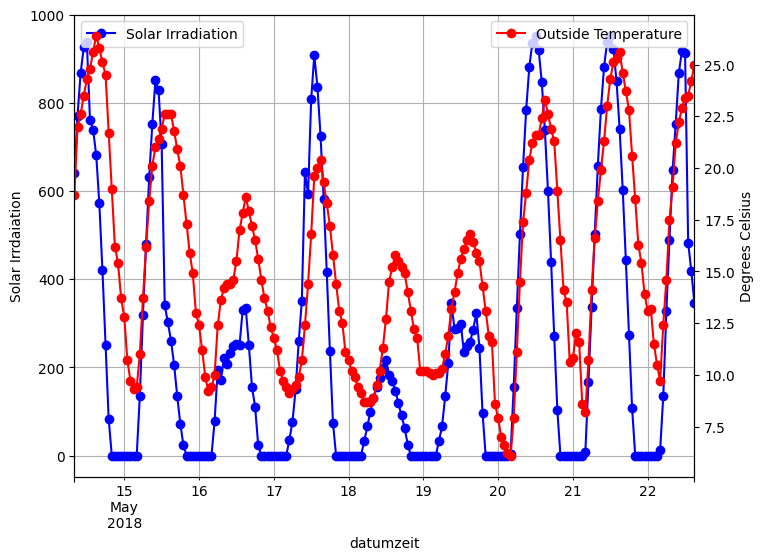

In [16]:
# plot a subset of the data
fig,ax=plt.subplots(figsize=(8,6))
axtwin = ax.twinx()
df_weather_IRR_2018.iloc[3200:3400].plot(x="datumzeit", y="SOL_IRR", ax=ax, marker="o", color="blue")
df_weather_TM_2018.iloc[3200:3400].plot(x="datumzeit", y="TM", ax=axtwin, marker="o", color="red")
ax.legend(["Solar Irradiation"],loc="upper left")
ax.set_ylabel("Solar Irrdaiation")
axtwin.set_ylabel("Degrees Celsius")
axtwin.legend(["Outside Temperature"],loc="upper right")
ax.grid(which='both', axis='both', linestyle='-');

The peaks corresponding to the daily peaks in solar radiation and the daily ups and downs in the temperature can be discerned in the above picture.

## Getting the electricity data

The electricity data is stored in `2018_data_60min.hdf5`. The same principle for reading the `hdf5` file for the electricity data by using the `keys()` method. As can be verified, the first level of applying `keys()` gives us:

* `MISC`, `NO_PV` and `PV`.

As the documentation in the paper explains, `PV` refers to households with photovoltaic and `NO_PV` refers to buildings without photovoltaic. Applying `keys()` to `NO_PV` gives us:

* `SFH4`, `SFH5`, `SFH6`, etc. These are the IDs of the different households whose data is available. Again applying `keys()` to each one of these in turn gives us:

* `HEATPUMP`, `HOUSEHOLD`. The former refers to electrical power data of heatpumps and the latter to electrical power data of the entire household. We will focus on `HEATPUMP` here. Applying `keys()` to `HEATPUMP` gives us again:

* `table`

where the data is saved with the following column names:

* `index`, `S_1`, `S_2`, `S_3`, `S_TOT`, `I_1`, `I_2`, `I_3`, `PF_1`, `PF_2`, `PF_3`, `PF_TOT`, `P_1`, `P_2`, `P_3`, `P_TOT`, `Q_1`, `Q_2`,   `Q_3`, `Q_TOT`, `U_1`, `U_2`, `U_3`

The above are various types of electrial power and related quantitites. The details are given in the paper.

In [17]:
filename = "/home/kbhaskar/Github_Repos/DataScience/DataVisualization/2018_data_60min.hdf5"
f = h5py.File(filename, 'r')

In [18]:
print(list(f["NO_PV"].keys()))

['SFH10', 'SFH11', 'SFH12', 'SFH14', 'SFH16', 'SFH17', 'SFH18', 'SFH19', 'SFH20', 'SFH21', 'SFH22', 'SFH23', 'SFH24', 'SFH25', 'SFH27', 'SFH28', 'SFH29', 'SFH3', 'SFH30', 'SFH31', 'SFH32', 'SFH34', 'SFH35', 'SFH36', 'SFH37', 'SFH38', 'SFH39', 'SFH4', 'SFH40', 'SFH5', 'SFH6', 'SFH7', 'SFH8', 'SFH9']


In [19]:
print(list(f["NO_PV"]["SFH10"].keys()))

['HEATPUMP', 'HOUSEHOLD']


In [20]:
print(list(f["NO_PV"]["SFH10"]["HEATPUMP"].keys()))

['table']


In [21]:
pd.DataFrame(f["NO_PV"]["SFH10"]["HEATPUMP"]["table"][()])

,index,S_TOT,PF_TOT,P_1,P_2,P_3,P_TOT,Q_1,Q_2,Q_3,Q_TOT
0,1514764800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1514768400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1514772000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1514775600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1514779200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
8755,1546282800,1616.924416,0.565111,456.531390,368.470582,295.588666,1120.593722,343.827752,447.830028,341.702472,1133.368086
8756,1546286400,1476.828112,0.583783,397.970916,275.535028,235.214276,908.716361,344.768305,442.726501,339.942332,1127.433720
8757,1546290000,1821.138500,0.592744,500.326167,375.096749,310.075638,1186.177165,410.977472,526.251195,404.992777,1342.220250
8758,1546293600,1057.947357,0.515258,291.735029,214.413834,175.905612,682.041526,234.802638,313.390834,230.653889,778.845696


As Table 4 in the article mentions: 

* $P_1$, $P_2$, $P_3$ and $P_{TOT}$ refer to active power.
* $Q_1$, $Q_2$, $Q_3$ and $Q_{TOT}$ refer to reactive power.
* $S_TOT$ refers to apparent power.


For the purpose of this article we will look at $P_{TOT}$ which is the active power and is the power for which the consumer [pays](https://eshop.se.com/in/blog/post/difference-between-active-power-reactive-power-and-apparent-power.html). Let's write a function to get the data for any particular household:

In [22]:
def get_electricity_data(year=2018, hid="SFH10"):
    filename = "./{}_data_60min.hdf5".format(year)
    f = h5py.File(filename, 'r')
    df = pd.DataFrame(np.array(f["NO_PV"][hid]["HEATPUMP"]["table"][()]))
    df["datumzeit"] = pd.to_datetime(df["index"], unit="s")
    df["datum"] = df["datumzeit"].dt.normalize()
    df["hid"] = hid
    return df

For exmample, the data of `SFH4` can be obtained as (as the paper mentions, the electricity data for 2018 are available only from May, hence the `NaN`s below):

In [23]:
get_electricity_data(hid="SFH4").head()

,index,S_TOT,PF_TOT,P_1,P_2,P_3,P_TOT,Q_1,Q_2,Q_3,Q_TOT,datumzeit,datum,hid
0,1514764800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-01-01 00:00:00,2018-01-01,SFH4
1,1514768400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-01-01 01:00:00,2018-01-01,SFH4
2,1514772000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-01-01 02:00:00,2018-01-01,SFH4
3,1514775600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-01-01 03:00:00,2018-01-01,SFH4
4,1514779200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-01-01 04:00:00,2018-01-01,SFH4


# Getting electricity and weather data in a single dataframe

Here's a function that merges the elctricity and weather data into a single dataframe for a given household ID:

In [24]:
def get_heatpump_weather(year=2018, hid="SFH10", wvar="WEATHER_TEMPERATURE_TOTAL"):
    df_heatpump = get_electricity_data(year, hid)
    dfweather = get_weather(year, wvar)
    df = pd.merge(df_heatpump, dfweather, on="datumzeit")
    df = df.drop(["index_x", "index_y", "datum"], axis=1)
    return df

For example the data for `SFH4` and 2018:

In [25]:
get_heatpump_weather(year=2018, hid="SFH10", wvar="WEATHER_TEMPERATURE_TOTAL").head()

,S_TOT,PF_TOT,P_1,P_2,P_3,P_TOT,Q_1,Q_2,Q_3,Q_TOT,datumzeit,hid,TM
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-01-01 00:00:00,SFH10,9.8
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-01-01 01:00:00,SFH10,9.8
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-01-01 02:00:00,SFH10,9.2
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-01-01 03:00:00,SFH10,8.4
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-01-01 04:00:00,SFH10,8.5


# Data Visualization: Part 1

Now that we have the functions for putting the data into a usable form, we can proceed with the next step of visualizing the data. I'll use data from `SFH4`, `SFH8`, `SFH10`, although of course any other households can be used. I'll save the corresponding dataframes into a list called `dflist`. In the next step I'll obtain the daily aggregates of the data and visualize it.

In [26]:
years = [2018, 2019]
houses = ["SFH4", "SFH8", "SFH10"]
dflist = []
for h in houses:
    for year in years:
        df = get_heatpump_weather(year=year, hid=h)
        dflist.append(df)
        
dfconcat = pd.concat(dflist)

Let us check if there are repetitions in the datumzeit columns (which could be because the ending date for the 2018 weather data is the same as the beginning date of the 2019 weather data).

In [31]:
dfconcat.duplicated(subset=["datumzeit", "hid"]).sum()

0

The above shows that no duplicate values of `hid`-`datumzeit` pairs. Just in case we have repetitions, we can easily take care of this with:

In [32]:
#dfconcat = dfconcat.drop_duplicates(subset=["hid", "datumzeit"])

There are some NAs in `P_TOT`, which we will remove with `dropna()`

In [33]:
dfconcat.isna().sum()

S_TOT        9001
PF_TOT       9001
P_1          9238
P_2          9238
P_3          9238
P_TOT        9001
Q_1          9238
Q_2          9238
Q_3          9238
Q_TOT        9001
datumzeit       0
hid             0
TM              0
dtype: int64

In [34]:
# remove NAs in P_TOT
dfconcat = dfconcat.dropna(subset="P_TOT")

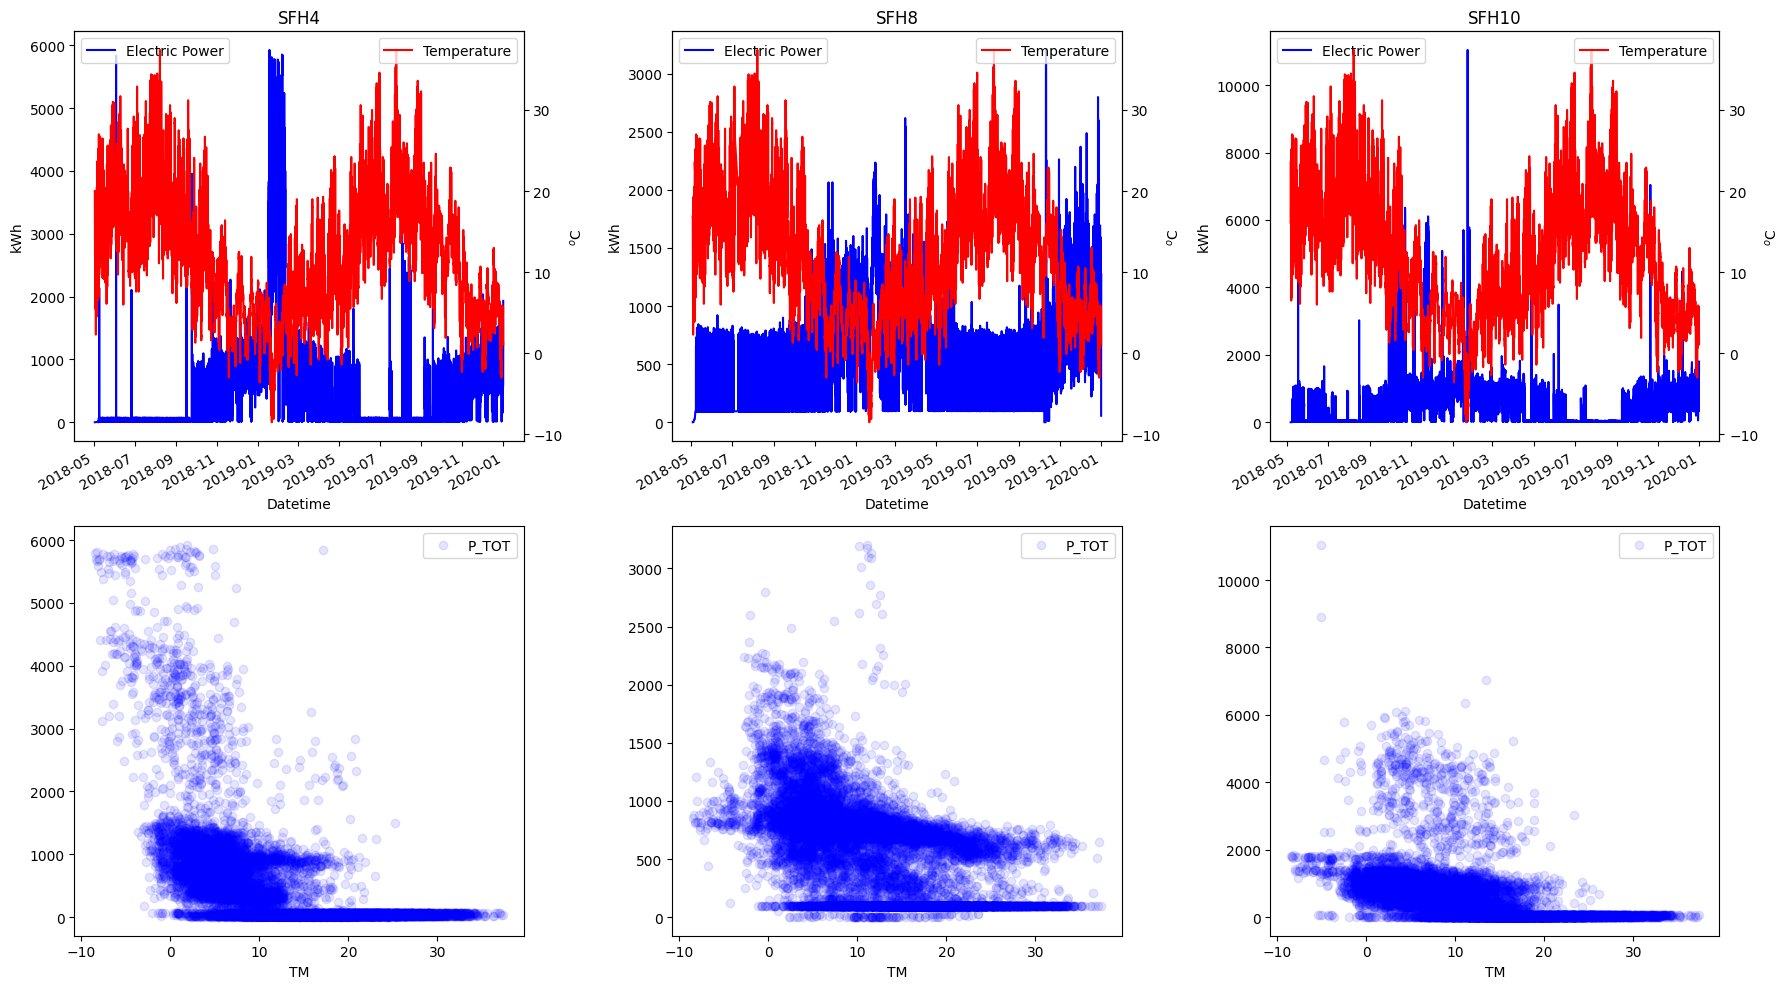

In [32]:
fig,ax=plt.subplots(2,3,figsize=(18,10))
for i, (key, df_group) in enumerate(dfconcat.groupby("hid")):
    j = {"SFH4":0, "SFH8":1, "SFH10":2}[key]
    axtwinx = ax[0][j].twinx()
    df_group.plot(x="datumzeit",y="P_TOT", ax=ax[0][j], color="blue")
    df_group.plot(x="datumzeit",y="TM", ax=axtwinx, color="red")
    df_group.plot(x="TM",y="P_TOT",ax=ax[1][j], color="blue", marker="o",linestyle="None",alpha=0.1)
    ax[0][j].legend(["Electric Power"], loc="upper left")
    axtwinx.legend(["Temperature"], loc="upper right")
    ax[0][j].set_xlabel("Datetime")
    ax[0][j].set_ylabel("kWh")
    ax[0][j].set_title(key)
    axtwinx.set_ylabel("$^o$C")
plt.tight_layout()

There are some clusters in the above pictures whose source is not clear. I have checked if these arise due to different usage patterns during day and night, but that doesn't seem to be the case. It's also surprising that  there is a nonzero usage even for temperatures upto 30 degrees Celsius, as shown by the two horizontal clusters in the bottom panel, most clearly in SFH8. Let us have a quick look at SH8 between 3 July and 5 July 2019:

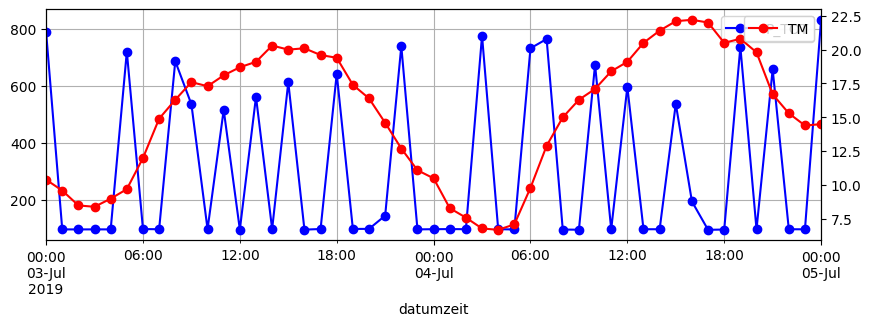

In [35]:
fig,ax=plt.subplots(figsize=(10,3))
axtwinx = ax.twinx()
inrange = dfconcat["datumzeit"].between("2019-07-03", "2019-07-05")
dfconcat.loc[(dfconcat["hid"]=="SFH8")&inrange].plot(x="datumzeit", y="P_TOT", marker="o", ax=ax, color="blue")
dfconcat.loc[(dfconcat["hid"]=="SFH8")&inrange].plot(x="datumzeit", y="TM", marker="o", ax=axtwinx, color="red")
ax.grid(which='both', axis='both', linestyle='-');

The picture shows that the power switches between 0 and about 700 kW every few hours. Offhand there doesn't seem to be a particular pattern in this switching though, and more effort will be required to understand it. I suppose the system checks for the inside temperature set by the user and adjusts the power accordingly. Let us next look at data aggregated over a daily basis. 

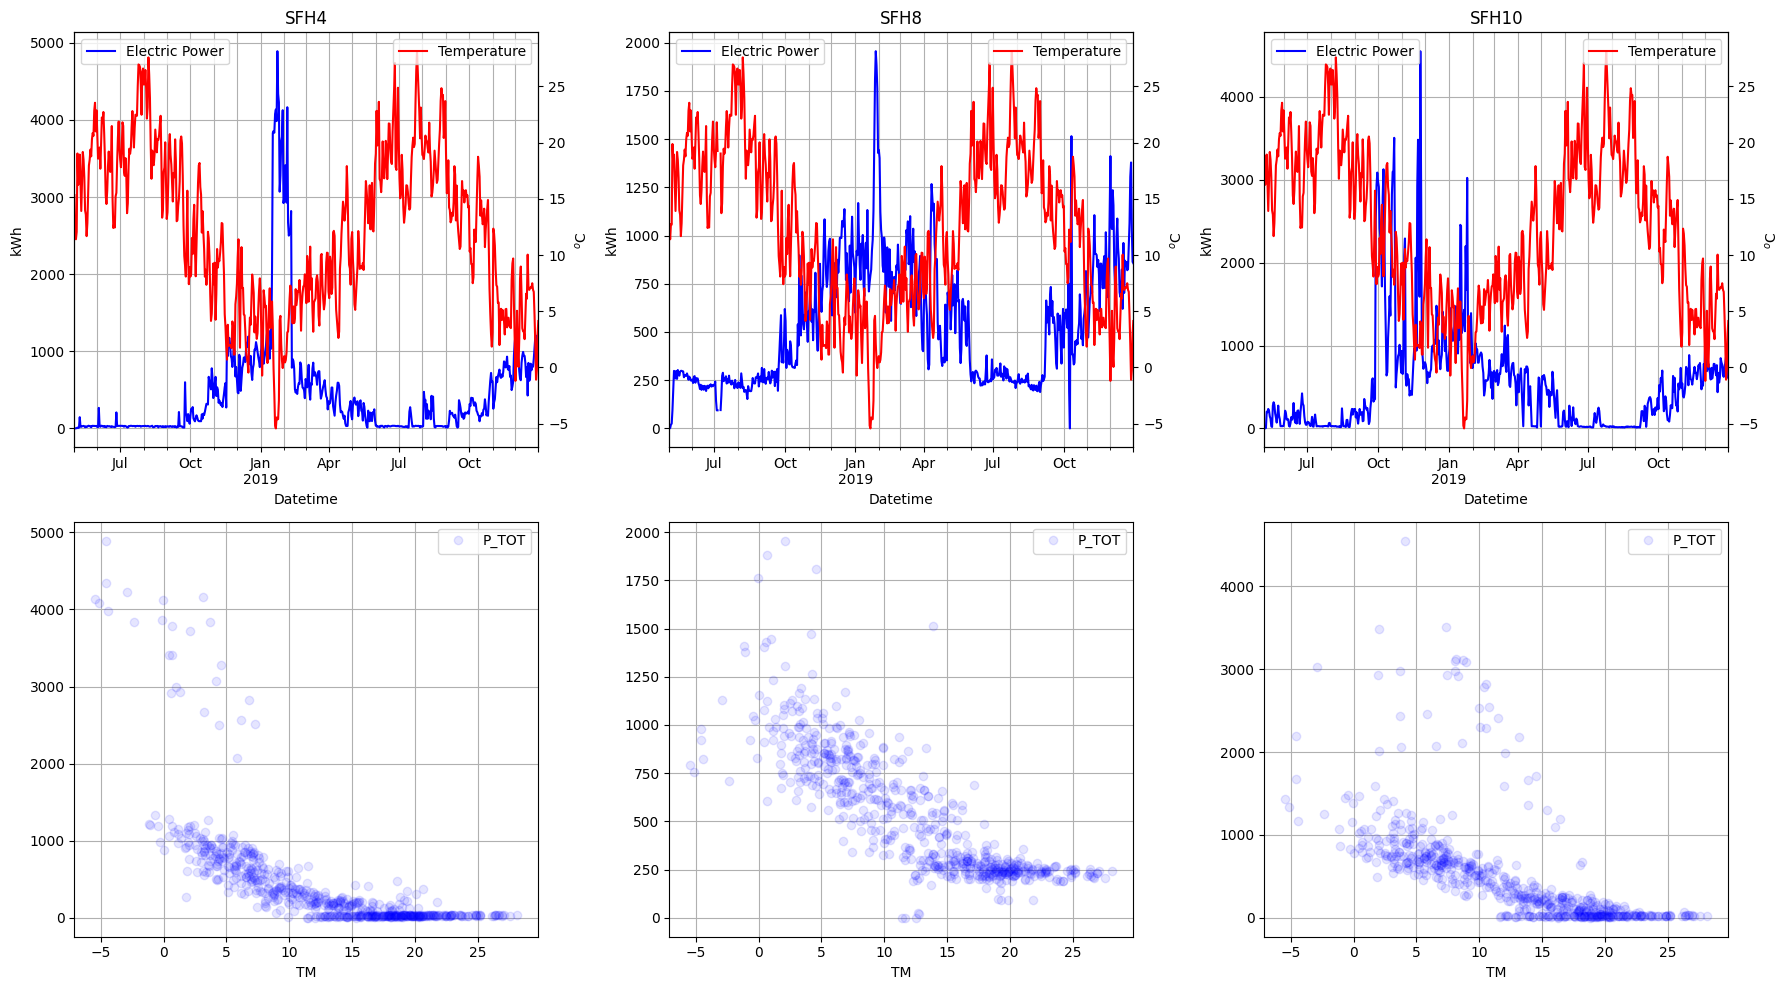

In [38]:
fig,ax=plt.subplots(2,3,figsize=(18,10))
for i, (key, df_group_) in enumerate(dfconcat.groupby("hid")):
    j = {"SFH4":0, "SFH8":1, "SFH10":2}[key]
    axtwinx = ax[0][j].twinx()
    df_group = df_group_.copy()
    df_group.index = df_group["datumzeit"]
    df_group = df_group.resample("D").mean()
    df_group.plot(y="P_TOT", ax=ax[0][j], color="blue")
    df_group.plot(y="TM", ax=axtwinx, color="red")
    df_group.plot(x="TM",y="P_TOT",ax=ax[1][j], color="blue", marker="o",linestyle="None",alpha=0.1)
    ax[0][j].legend(["Electric Power"], loc="upper left")
    axtwinx.legend(["Temperature"], loc="upper right")
    ax[0][j].set_xlabel("Datetime")
    ax[0][j].set_ylabel("kWh")
    ax[0][j].set_title(key)
    axtwinx.set_ylabel("$^o$C")
    ax[0][j].grid(which='both', axis='both', linestyle='-')
    ax[1][j].grid(which='both', axis='both', linestyle='-')
plt.tight_layout();